# Working model
**Version 13a**:
- Word level tokens
- GRU type RNNs
- 'sparse_categorical_crossentropy' to save memory
- dropout to hinder overfitting

**Conclusions:**
- 'sparse' works!
- 'sparse' runs 6x faster, strange, perhaps less work on fewer data?
- testing 'dropout', works soso
- 'so so' translation, perfect on training data, bad on validation data

**Improvments to be implemented:**
- randomize input data?
- try / understand 'TimeDistributed': decoder_dense = TimeDistributed(Dense(Y_lstm.shape[2], activation = 'relu'))
- **Done** dropout in RNN layer:
- dropout as layer
- L2 reg
- **Done** Simplify by suing GRU RNN
- **Done** ' to_categorical' as one-hot encoder, makes huge matrices
- **Done** "sparse_categorical_crossentropy" to reduce the 'one hot' tensor
- operates right now with long sentences: 8*std_div, shound be less when longer sentences are trained
- deeper models to represent more complex sentences, more RNN layers?
- bi-directional layers: https://stackoverflow.com/questions/50815354/seq2seq-bidirectional-encoder-decoder-in-keras
- train on larger dataset
- model.fit_generator to handle larger datasets
- attention 
- Gradient clipping is important for RNNs training (clipvalue=1.0), book page 309
- test: metrics=['accuracy']
- **Done** something is wrong with the index of the one-hot; the model allows to return "0" as the best index, but the token2word starts from "1". It seems to be OK
- set 'return_sequences' or 'return_stage' to false in models? Something is rotten

**Credits to many fine people on the internet:**
- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
- https://medium.com/@dev.elect.iitd/neural-machine-translation-using-word-level-seq2seq-model-47538cba8cd7
- https://stackoverflow.com/questions/49477097/keras-seq2seq-word-embedding
- https://github.com/devm2024/nmt_keras/blob/master/base.ipynb
- https://www.kaggle.com/ievgenvp/lstm-encoder-decoder-via-keras-lb-0-5

In [1]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, GRU, Dense
from tensorflow.python.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import numpy as np

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.__version__

'1.5.0'

In [3]:
tf.keras.__version__

'2.1.2-tf'

In [4]:
# global variables

num_samples = 100000       # Number of samples to train on
num_words = 10000          # Limit vocabulary in translation
latent_dim = 256           # Latent dimensionality of the encoding space

batch_size = 512           # Batch size for training.
numEpochs = 200            # Number of epochs to train for.
DropOut = 0.4              # Used in GRU layers

truncate_std_div = 99      # truncate sentences after x tokens
mark_start = 'ssss '       # start and end markes for destination sentences
mark_end = ' eeee'

data_path = 'dan-eng/dan.txt'

### Read training data into tables

In [5]:
# Read data into tables
input_texts = []
target_texts = []

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_sentence, target_sentence = line.split('\t')
    target_sentence = mark_start + target_sentence.strip() + mark_end
    input_texts.append(input_sentence)
    target_texts.append(target_sentence)

# Examples
print(input_texts[15:20])
print(target_texts[15:20])

['No way!', 'No way!', 'No way!', 'No way!', 'No way!']
['ssss Aldrig i livet! eeee', 'ssss Ikke tale om! eeee', 'ssss Absolut ikke! eeee', 'ssss Under ingen omstændigheder! eeee', 'ssss Aldrig i verden! eeee']


### Tokenize input sentences

In [6]:
# crate input tokenizer and create vocabulary from the texts
tokenizer_inp = Tokenizer(num_words=num_words)
tokenizer_inp.fit_on_texts(input_texts)
print('Found %s unique source tokens.' % len(tokenizer_inp.word_index))

# translate from word sentences to token sentences
tokens_inp = tokenizer_inp.texts_to_sequences(input_texts)

# Shorten the longest token sentences, Find the length of all sentences, truncate after x * std deviations
num_tokens = [len(x) for x in tokens_inp]
print('Longest sentence is %s tokens.' % max(num_tokens))
max_tokens_input = np.mean(num_tokens) + truncate_std_div * np.std(num_tokens)
max_tokens_input = min(int(max_tokens_input), max(num_tokens))
print('Sentences shortened to max %s tokens.' % max_tokens_input)

# Pad / truncate all token-sequences to the given length
tokens_padded_input = pad_sequences(tokens_inp,
                                    maxlen=max_tokens_input,
                                    padding='post',
                                    truncating='post')
print('Shape of input tokens:', tokens_padded_input.shape)
print('Input example: ', tokens_padded_input[10000])

# Create inverse lookup from integer-tokens to words
index_to_word_input = dict(zip(tokenizer_inp.word_index.values(), tokenizer_inp.word_index.keys()))

# function to return readable text from tokens string
def tokens_to_string_inp(tokens):
    words = [index_to_word_input[token] 
            for token in tokens
            if token != 0]
    text = " ".join(words)
    return text

# demo to show that it works
idx = 10000
print(tokens_to_string_inp(tokens_padded_input[idx]))
print(input_texts[idx])
print(tokens_padded_input[idx])

Found 5293 unique source tokens.
Longest sentence is 24 tokens.
Sentences shortened to max 24 tokens.
Shape of input tokens: (14839, 24)
Input example:  [   1   73    6   29  531 1326  360    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
the apple is not quite ripe yet
The apple is not quite ripe yet.
[   1   73    6   29  531 1326  360    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


### Tokenize destination sentences

In [7]:
# crate input tokenizer and create vocabulary from the texts
tokenizer_target = Tokenizer(num_words=num_words)
tokenizer_target.fit_on_texts(target_texts)
print('Found %s unique target tokens.' % len(tokenizer_target.word_index))

# translate from word sentences to token sentences
tokens_target = tokenizer_target.texts_to_sequences(target_texts)

# translate from word sentences to token sentences
tokens_target = tokenizer_target.texts_to_sequences(target_texts)

# Shorten the longest token sentences, Find the length of all sentences, truncate after x * std deviations
num_tokens = [len(x) for x in tokens_target]
print('Longest sentence is %s tokens.' % max(num_tokens))
max_tokens_target = np.mean(num_tokens) + truncate_std_div * np.std(num_tokens)
max_tokens_target = min(int(max_tokens_target), max(num_tokens))
print('Sentences shortened to max %s tokens.' % max_tokens_target)

# Pad / truncate all token-sequences to the given length
tokens_padded_target = pad_sequences(tokens_target,
                                     maxlen=max_tokens_target,
                                     padding='post',
                                    truncating='post')
print('Shape of target tokens:', tokens_padded_target.shape)
print('Target example: ', tokens_padded_target[10000])

# Create inverse lookup from integer-tokens to words
index_to_word_target = dict(zip(tokenizer_target.word_index.values(), tokenizer_target.word_index.keys()))

# function to return readable text from tokens string
def tokens_to_string_target(tokens):
    words = [index_to_word_target[token] 
            for token in tokens
            if token != 0]
    text = " ".join(words)
    return text

# demo to show that it works
idx = 10000
print(tokens_to_string_target(tokens_padded_input[idx]))
print(target_texts[idx])
print(tokens_padded_target[idx])

Found 7070 unique target tokens.
Longest sentence is 29 tokens.
Sentences shortened to max 29 tokens.
Shape of target tokens: (14839, 29)
Target example:  [   1  308    3   10  194 2333  273    2    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
ssss tror at den problemer faldet 30
ssss Æblet er ikke helt modent endnu. eeee
[   1  308    3   10  194 2333  273    2    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [8]:
# start and end marks as tokens, needed when translating
token_start = tokenizer_target.word_index[mark_start.strip()]
token_end = tokenizer_target.word_index[mark_end.strip()]
print(token_start, token_end)

1 2


### Traing data
- Input to the encoder is simply the source language as it is
- Inputs to the decoder are slightly more complicated, since the two input strings are shiften one time-step: The model has to learn to predict the "next" token in the output from the input. Slizing is used to get two "views" to the data

In [9]:
encoder_input_data = tokens_padded_input
encoder_input_data.shape

(14839, 24)

In [10]:
decoder_input_data = tokens_padded_target[:, :-1]
decoder_input_data.shape

(14839, 28)

In [11]:
decoder_target_data = tokens_padded_target[:, 1:]
decoder_target_data.shape

(14839, 28)

Examples showing the training data to the model

In [12]:
encoder_input_data[idx]

array([   1,   73,    6,   29,  531, 1326,  360,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0])

In [13]:
decoder_input_data[idx]

array([   1,  308,    3,   10,  194, 2333,  273,    2,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [14]:
decoder_target_data[idx]

array([ 308,    3,   10,  194, 2333,  273,    2,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

One-hot encode 'decoder_target_data' since this is what the decoder produces as output

### Create training model

In [15]:
# GRU encoder
encoder_inputs = Input(shape=(None,))

encoder_embed = Embedding(num_words, latent_dim)
encoder_embed_final = encoder_embed(encoder_inputs)

encoder = GRU(latent_dim, dropout=DropOut, recurrent_dropout=DropOut, return_state=True)
encoder_outputs, state_h = encoder(encoder_embed_final)

In [16]:
# Set up GRU decoder, using `encoder_states` as initial state
decoder_inputs = Input(shape=(None,))

decoder_embed = Embedding(num_words, latent_dim)
decoder_embed_final = decoder_embed(decoder_inputs)

decoder_gru = GRU(latent_dim, dropout=DropOut, recurrent_dropout=DropOut, return_sequences=True, return_state=True)            
decoder_outputs, dec_states_h = decoder_gru(decoder_embed_final, initial_state=state_h)

decoder_dense = Dense(num_words, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2560000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    2560000     input_2[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU

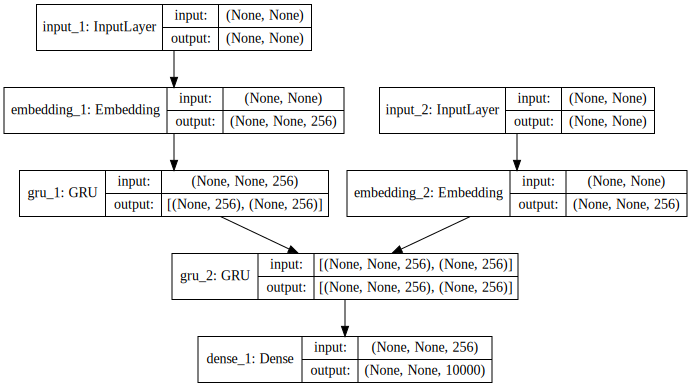

In [17]:
# visualise model as a graph
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydot_ng as pydot
import graphviz as graphviz
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

### Train the model

In [18]:
# custom loss function since sparse does not work: https://github.com/tensorflow/tensorflow/issues/17150
def sparse_cross_entropy(y_true, y_pred):
    # Calculate the loss. This outputs a 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [19]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

In [20]:
model.compile(optimizer='rmsprop',
              loss=sparse_cross_entropy,
              target_tensors=[decoder_target])

In [32]:
# Note that `decoder_target_data` needs to be one-hot encoded,
# rather than sequences of integers like `decoder_input_data`!
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,                # _onehot
                    batch_size=batch_size,
                    epochs=numEpochs,
                    validation_split=0.2)
model.save('TGC_trans.h5')

Train on 11871 samples, validate on 2968 samples
Epoch 1/200
11871/11871 [==============================] - 4s 346us/step - loss: 0.0631 - val_loss: 2.1914
Epoch 2/200
11871/11871 [==============================] - 4s 340us/step - loss: 0.0629 - val_loss: 2.2076
Epoch 3/200
11871/11871 [==============================] - 4s 339us/step - loss: 0.0617 - val_loss: 2.1970
Epoch 4/200
11871/11871 [==============================] - 4s 344us/step - loss: 0.0609 - val_loss: 2.2078
Epoch 5/200
11871/11871 [==============================] - 4s 344us/step - loss: 0.0608 - val_loss: 2.2017
Epoch 6/200
11871/11871 [==============================] - 4s 344us/step - loss: 0.0602 - val_loss: 2.2034
Epoch 7/200
11871/11871 [==============================] - 4s 340us/step - loss: 0.0596 - val_loss: 2.1967
Epoch 8/200
11871/11871 [==============================] - 4s 339us/step - loss: 0.0592 - val_loss: 2.2286
Epoch 9/200
11871/11871 [==============================] - 4s 343us/step - loss: 0.0591 - val_l

11871/11871 [==============================] - 4s 345us/step - loss: 0.0366 - val_loss: 2.3387
Epoch 77/200
11871/11871 [==============================] - 4s 341us/step - loss: 0.0368 - val_loss: 2.3356
Epoch 78/200
11871/11871 [==============================] - 4s 340us/step - loss: 0.0363 - val_loss: 2.3521
Epoch 79/200
11871/11871 [==============================] - 4s 347us/step - loss: 0.0367 - val_loss: 2.3523
Epoch 80/200
11871/11871 [==============================] - 4s 342us/step - loss: 0.0366 - val_loss: 2.3377
Epoch 81/200
11871/11871 [==============================] - 4s 343us/step - loss: 0.0364 - val_loss: 2.3571
Epoch 82/200
11871/11871 [==============================] - 4s 346us/step - loss: 0.0357 - val_loss: 2.3346
Epoch 83/200
11871/11871 [==============================] - 4s 343us/step - loss: 0.0361 - val_loss: 2.3386
Epoch 84/200
11871/11871 [==============================] - 4s 354us/step - loss: 0.0358 - val_loss: 2.3528
Epoch 85/200
11871/11871 [===============

11871/11871 [==============================] - 4s 350us/step - loss: 0.0271 - val_loss: 2.4427
Epoch 152/200
11871/11871 [==============================] - 4s 355us/step - loss: 0.0281 - val_loss: 2.4348
Epoch 153/200
11871/11871 [==============================] - 4s 356us/step - loss: 0.0274 - val_loss: 2.4196
Epoch 154/200
11871/11871 [==============================] - 4s 354us/step - loss: 0.0275 - val_loss: 2.4393
Epoch 155/200
11871/11871 [==============================] - 4s 362us/step - loss: 0.0272 - val_loss: 2.4319
Epoch 156/200
11871/11871 [==============================] - 4s 360us/step - loss: 0.0273 - val_loss: 2.4361
Epoch 157/200
11871/11871 [==============================] - 4s 360us/step - loss: 0.0276 - val_loss: 2.4263
Epoch 158/200
11871/11871 [==============================] - 4s 358us/step - loss: 0.0267 - val_loss: 2.4316
Epoch 159/200
11871/11871 [==============================] - 4s 359us/step - loss: 0.0270 - val_loss: 2.4392
Epoch 160/200
11871/11871 [======

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\keras\engine\topology.py:2368: UserWarning: Layer gru_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_1/while/Exit_2:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'loss'])

In [23]:
import matplotlib.pyplot as plt
plt.show()

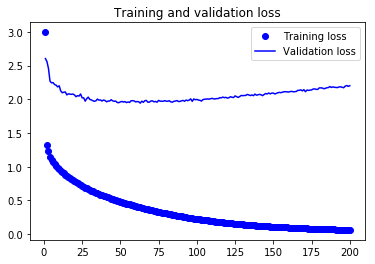

In [24]:
# plotter historikken for 'loss'
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, numEpochs+1)
plt.plot(epochs, loss, 'bo', label='Training loss')       # bo = "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b  = "solid blue line"
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Inference mode = testing the model

### create sampling model

In [25]:
# encoder model used to create internal representation / states
encoder_model = Model(encoder_inputs, state_h)
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
gru_1 (GRU)                  [(None, 256), (None, 256) 393984    
Total params: 2,953,984
Trainable params: 2,953,984
Non-trainable params: 0
_________________________________________________________________


In [26]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_inputs = [decoder_state_input_h,]

# reuse the decoder we have trained
decoder_embed_final2 = decoder_embed(decoder_inputs)

decoder_outputs2, state_h2 = decoder_gru(decoder_embed_final2, initial_state=decoder_state_inputs)

decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_state_inputs, 
    [decoder_outputs2] + [state_h2])                    # notice the '+' operator requires [] to work !!!

decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    2560000     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
gru_2 (GRU)                     [(None, None, 256),  393984      embedding_2[1][0]                
                                                                 input_3[0][0]                    
__________

In [27]:
def decode_sequence(input_seq):
   
    # tokenize the text to be translated, and reverse
    input_tokens = tokenizer_inp.texts_to_sequences([input_seq])
    input_tokens = pad_sequences(input_tokens,
                                 maxlen=max_tokens_input,
                                 padding='post',
                                 truncating='post')

    # encode the input sentence
    states_value = encoder_model.predict(input_tokens)
    
    # Generate empty target sequence of length 1 and insert start token
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = token_start    #

    # sampling loop to generate translated words using decoder, word by word
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:  
        # predict one next word, decoder returns probabilities for all words/tokens
        output_tokens, h = decoder_model.predict([target_seq] + [states_value])
        
        # pick most probable token / word
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = index_to_word_target[sampled_token_index]
        decoded_sentence += ' '+sampled_word
        
        # Exit condition: either hit max length or find stop character.
        if (sampled_word == 'eeee' or len(decoded_sentence) > 52):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states, so they can be re-injected in next token/word prediction
        states_value = h

    return decoded_sentence

### Doing translation ...

In [33]:
# testing on known sentences from training data
for idx in range(6001, 6100):
    input_seq = input_texts[idx]
    decoded_sentence = decode_sequence(input_seq)
    print(input_seq, decoded_sentence, '\n')

You can't both be right.  i kan ikke begge have ret eeee 

You can't get rid of me.  du kan ikke slippe af med mig eeee 

You can't prove a thing.  du kan ikke bevise noget eeee 

You do not have a fever.  du har ikke feber eeee 

You don't know who I am.  du ved ikke hvem jeg er eeee 

You don't need to panic.  du behøver ikke at gå i panik eeee 

You have very sexy legs.  du har meget sexede ben eeee 

You left your lights on.  du har lys på eeee 

You left your lights on.  du har lys på eeee 

You must've been asleep.  du må have sovet eeee 

You need an interpreter.  du har brug for en tolk eeee 

You never stop learning.  man skal lære så længe man lever eeee 

You should quit smoking.  du burde holde op med at ryge eeee 

You should quit smoking.  du burde holde op med at ryge eeee 

You surprised everybody.  du overraskede alle eeee 

You won't have a choice.  du får ikke et valg eeee 

You're a beautiful girl.  du er en smuk pige eeee 

You're a very lucky man.  du er en meget 

In [29]:
# testing on known sentences from validation data
for idx in range(12000, 12100):
    input_seq = input_texts[idx]
    decoded_sentence = decode_sequence(input_seq)
    print(input_seq, decoded_sentence, '\n')

I don't know and I don't want to know.  jeg ved ikke hvad jeg skal sige til det eeee 

I don't like learning irregular verbs.  jeg kan ikke lide at arbejde i haven eeee 

I don't like learning irregular verbs.  jeg kan ikke lide at arbejde i haven eeee 

I don't like the way she speaks to me.  jeg kan ikke lide at tale med oversygeplejersken eeee 

I get a call from her once in a while.  jeg har tænkt mig at kalde på en kat eeee 

I have a surprise for you, sweetheart.  jeg har en uge til at lave mad i dag eeee 

I have heard that song sung in French.  jeg har hørt hvert et ord eeee 

I have no problem letting others help.  jeg har ingen idé om hvad der skete eeee 

I heard a dog barking in the distance.  jeg har hørt om det i radioen eeee 

I hope that all your dreams come true.  jeg håber at det var din eneste chance eeee 

I know that some people value my work.  jeg ved hvor man arbejder på eeee 

I like May the best of all the months.  jeg kan bedre lide bananer end sort te eeee 



In [30]:
input_seq = 'see you later'
decoded_sentence = decode_sequence(input_seq)
print(input_seq, decoded_sentence, '\n')

see you later  vi ses eeee 



In [36]:
input_seq = 'how are you'
decoded_sentence = decode_sequence(input_seq)
print(input_seq, decoded_sentence, '\n')

how are you  hvordan har du det eeee 

